<a href="https://colab.research.google.com/github/SriSathwik1905/Diabetic-Retinopathy-VIT/blob/main/Vision_Transformer_(ViT)_%2B_CBAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets tensorflow_hub --upgrade
!pip install scikit-learn matplotlib seaborn opencv-python

ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 447, in run
    conflicts = self._determine_conflicts(to_install)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/commands/install.py", line 578, in _determine_conflicts
    return check_install_conflicts(to_install)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/operations/check.py", line 101, in check_install_conflicts
    package_set, _ = create_package_

# 📦 1. Install and Import Required Libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras import layers, models, optimizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📁 2. Load Dataset using opendatasets (or manually if downloaded)

In [ ]:
import opendatasets as od
# Example: Replace with your actual Kaggle dataset URL
od.download('https://www.kaggle.com/datasets/kssanjaynithish03/retinal-fundus-images')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vanshbharadwaj
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/kssanjaynithish03/retinal-fundus-images


# 🧼 3. Preprocessing + Data Augmentation

In [ ]:
train_dir = r"/content/retinal-fundus-images/Retinal Fundus Images/train"
val_dir = r"/content/retinal-fundus-images/Retinal Fundus Images/val"
test_dir = r"/content/retinal-fundus-images/Retinal Fundus Images/test"

# Class mapping (ordinal)
dr_stage_mapping = {'3.Mild DR': 0, '4.Moderate DR': 1, '5.Severe DR': 2, '6.Proliferate DR': 3}
img_size = 224
batch_size = 32

# Updated data augmentation with more variability
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2
)

train_data = datagen.flow_from_directory(train_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', classes=list(dr_stage_mapping.keys()))
val_data = datagen.flow_from_directory(val_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', classes=list(dr_stage_mapping.keys()))
test_data = datagen.flow_from_directory(test_dir, target_size=(img_size, img_size), batch_size=batch_size, class_mode='sparse', shuffle=False, classes=list(dr_stage_mapping.keys()))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=train_data.classes)
class_weights_dict = dict(enumerate(class_weights))

Found 10206 images belonging to 4 classes.
Found 211 images belonging to 4 classes.
Found 516 images belonging to 4 classes.


# 🔧 4. Define CBAM and ECA Blocks

In [ ]:
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = layers.Dense(channel // ratio, activation='relu')
    shared_layer_two = layers.Dense(channel)
    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    cbam_feature = layers.Reshape((1, 1, channel))(cbam_feature)
    channel_refined = layers.Multiply()([input_feature, cbam_feature])
    avg_pool = layers.GlobalAveragePooling2D()(channel_refined)
    max_pool = layers.GlobalMaxPooling2D()(channel_refined)
    spatial = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    spatial = layers.Reshape((1, 1, spatial.shape[-1]))(spatial)
    spatial = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(spatial)
    refined = layers.Multiply()([channel_refined, spatial])
    return refined


# 🧠 5. Vision Transformer + CBAM + ECA Model

In [ ]:
import tensorflow_hub as hub

def build_model_cbam_only():
    input_layer = layers.Input(shape=(img_size, img_size, 3))

    # Load Vision Transformer from TensorFlow Hub
    base_model = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_b16_fe/1", trainable=False)

    # Extract features from ViT
    x = layers.Lambda(lambda inputs: base_model(inputs, training=False))(input_layer)
    x = layers.Reshape((1, 1, -1))(x)  # Reshape for attention block

    # Apply CBAM block only
    x = cbam_block(x)

    # Global Average Pooling and final classification
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    output_layer = layers.Dense(4, activation='softmax')(x)  # 4 output classes

    model = models.Model(inputs=input_layer, outputs=output_layer)
    return model

model_cbam = build_model_cbam_only()
model_cbam.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cbam.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 768)            │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 768)      │              0 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 768)            │              0 │ reshape[0][0]          │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d      │ (None, 768)            │              0 │ reshape[0][0]          │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 96)             │         73,824 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling2d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 768)            │         74,496 │ dense[0][0],           │
│                           │                        │                │ dense[1][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 768)            │              0 │ dense_1[0][0],         │
│                           │                        │                │ dense_1[1][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 768)            │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 1, 1, 768)      │              0 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 1, 1, 768)      │              0 │ reshape[0][0],         │
│                           │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 768)            │              0 │ multiply[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling2d_1    │ (None, 768)            │              0 │ multiply[0][0]         │
│ (GlobalMaxPooling2D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1536)           │              0 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling2d_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_2 (Reshape)       │ (None, 1, 1, 1536)     │              0 │ concatenate[0][0]      │
├──────────────────────

 Total params: 322,533 (1.23 MB)

 Trainable params: 322,533 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

# 🚀 6. Train the Model

In [ ]:
history = model_cbam.fit(train_data, validation_data=val_data, epochs=20, class_weight=class_weights_dict)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 259s 773ms/step - accuracy: 0.4428 - loss: 1.0829 - val_accuracy: 0.6493 - val_loss: 0.7823
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 229s 717ms/step - accuracy: 0.5818 - loss: 0.8234 - val_accuracy: 0.6114 - val_loss: 0.8290
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 228s 713ms/step - accuracy: 0.6076 - loss: 0.7782 - val_accuracy: 0.5972 - val_loss: 0.8304
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 231s 723ms/step - accuracy: 0.6118 - loss: 0.7443 - val_accuracy: 0.7062 - val_loss: 0.7054
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 233s 731ms/step - accuracy: 0.6279 - loss: 0.7252 - val_accuracy: 0.6114 - val_loss: 0.7494
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 230s 721ms/step - accuracy: 0.6215 - loss: 0.7266 - val_accuracy: 0.6588 - val_loss: 0.7540
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 227s 712ms/step - accuracy: 0.6325 - loss: 0.7049 - val_accuracy: 0.6398 - val_loss: 0.7452
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 229s 716ms/step - accuracy: 0.6329 -

# 📊 7. Plot Training and Validation Curves

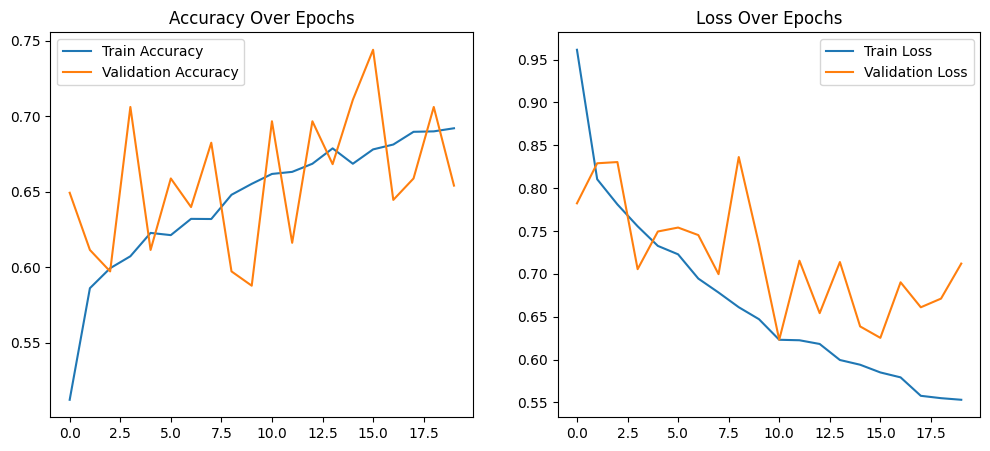

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.show()


# 📈 8. Evaluate Model (Confusion Matrix, Classification Report, ROC)

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 918ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.67      0.56       102
           1       0.72      0.56      0.63       216
           2       0.61      0.67      0.64       107
           3       0.67      0.65      0.66        91

    accuracy                           0.62       516
   macro avg       0.62      0.64      0.62       516
weighted avg       0.64      0.62      0.62       516



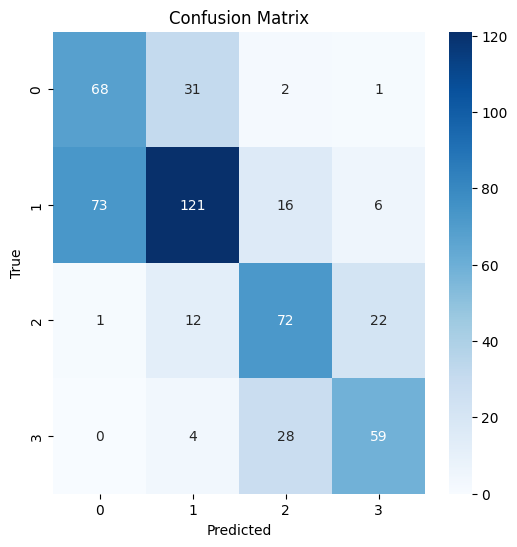

In [ ]:
preds = model_cbam.predict(test_data)
y_true = test_data.classes
y_pred = np.argmax(preds, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


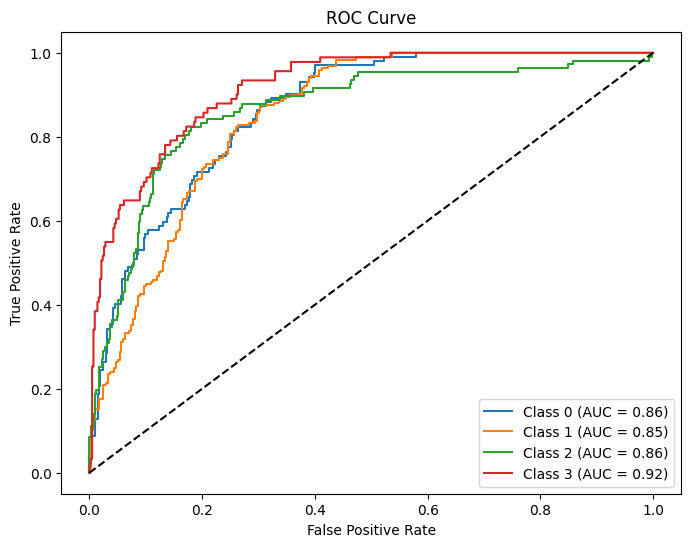

In [ ]:
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):  # Adjusted for 4 classes
    fpr[i], tpr[i], _ = roc_curve(y_true == i, preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(4):  # Adjusted for 4 classes
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 🔍 9. Grad-CAM Visualization

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


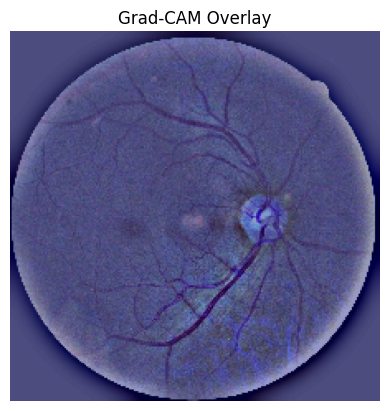

In [ ]:
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv2d"):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Example use on one image
img_path = test_data.filepaths[0]
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_size, img_size))
img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

heatmap = make_gradcam_heatmap(img_array, model_cbam)
plt.imshow(img)
plt.imshow(cv2.resize(heatmap, (224, 224)), cmap='jet', alpha=0.4)
plt.title("Grad-CAM Overlay")
plt.axis('off')
plt.show()
